## Disaster Tweets Project

### Introduction to problem and data

With social media quickly becoming one of the primary ways that people get news, it becomes important to be able to classify social media messages as they are posted to more easily search and propagate important messages. Machine learning, specifically NLP models, provide an automated way to parse a central meaning out of such messages to determine their context.

In this project, we will sample a dataset of tweets split between tweets about disasters and regular tweets to attempt to identify which tweets are about emergencies.

The dataset we will be working with has 10000 rows with each row containing the raw text of a tweet, an id, and a target column that indicates 1 if the tweet is about a disaster. Some rows additionally contain a location and/or a keyword related to the tweet.

Github Repo: https://github.com/Midelan/DisasterTweetsKaggle/blob/main/DisasterTweetsKaggle.ipynb

In [3]:
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras_tuner

2024-10-13 19:46:38.829369: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-13 19:46:38.829809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 19:46:38.831978: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 19:46:38.837860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 19:46:38.858209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Exploratory Data Analysis

Observing our data we see two immediate concerns:

1.) Many rows are missing keywords and locations. Since this model is observing individual tweets the location is unlikely to be useful, any location can have a disaster. This will be mentioned again in areas for future research. Additionally since this excercise is to extract the meaning of the text we have decided not to use the keyword field, not only is it missing for much of our training data, but also training a model on keywords may make it difficult to use the model for it's intended purpose as most data in the field will not come pre labelled with a keyword.

2.) Tweets in the dataset have many variations on words, and extraneous characters. To solve this we use the popular nltk dataset to remove all stopwords (words such as "a", "the" or "is" that do not provide information about the subject of the tweet) punctuation (as an example "avalanche!" and "avalanche." likely are not significantly different in meaning, and having them as separate words in a small dataset probably loses more value than it gains.) and words three or less characters long (for similar reasons to stopwords, when we graphed the word frequency most short words were extremely common, meaning they do not provide much insight into what type of tweet a given string is as these short words are found in most tweets)

Finally we lemmatize words, which allows us to combine many forms of similar words such as running, runner, and run, as again they likely all have very similar meaning in tweets, and remove any remaining singleton words that only appear in one tweet. This removes misspellings, usernames, urls, and other such one off terms that are unlikely enough to appear in future tweets that they will not benefit our predictions. As shown this drops our dicitonary of relevant words to a manageable 4226.

We also graph our distribution of data between disaster tweets and non-disaster tweets, and while our data is slightly unbalanced in favor of non-disaster tweets, it stands to reason that most tweets in the real world will not be about disasters, so we choose to use the dataset as is instead of balancing it further.

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/midelan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/midelan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/midelan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
os.getcwd()
notebook_path = os.path.abspath("DisasterTweetsKaggle.ipynb")
data_path = os.path.join(os.path.dirname(notebook_path), "RawImports/train.csv")
data = pd.read_csv(data_path)

In [6]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
def removePunctuationAndStops(text):
    lemmatizer = WordNetLemmatizer()
    stops = stopwords.words("english")
    text = text.translate(str.maketrans("", "", string.punctuation))
    tweet = ""
    for word in text.split():
        lemma = lemmatizer.lemmatize(word)
        if word not in stops:
            tweet = tweet + " " + lemma
    return tweet

def tokenize(text):
    return nltk.tokenize.word_tokenize(text)

def removeShortAndInfrequentWords(text, dictionary):
    tweet = ""
    for word in text.split():
        if (len(word)>3 and dictionary[word]>2):
            tweet = tweet + " " + word
    return tweet

In [7]:
data["text_filtered"] = data.apply(lambda x: removePunctuationAndStops(x['text']), axis=1)

In [8]:
data

,id,keyword,location,text,target,text_filtered
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason earthquake May ALLAH Forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All resident asked shelter place notified off...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby Alaska smoke wildfir...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant crane holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The control wild fire ...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M194 0104 UTC5km S Volcano Hawaii httptcozDto...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating ebike collided car Littl...


In [9]:
data["tokens"] = data.apply(lambda x: tokenize(x['text_filtered']), axis=1)

In [10]:
data

,id,keyword,location,text,target,text_filtered,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason earthquake May ALLAH Forgive u,"[Our, Deeds, Reason, earthquake, May, ALLAH, F..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All resident asked shelter place notified off...,"[All, resident, asked, shelter, place, notifie..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation orde...,"[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby Alaska smoke wildfir...,"[Just, got, sent, photo, Ruby, Alaska, smoke, ..."
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant crane holding bridge collapse nearb...,"[Two, giant, crane, holding, bridge, collapse,..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The control wild fire ...,"[ariaahrary, TheTawniest, The, control, wild, ..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M194 0104 UTC5km S Volcano Hawaii httptcozDto...,"[M194, 0104, UTC5km, S, Volcano, Hawaii, httpt..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating ebike collided car Littl...,"[Police, investigating, ebike, collided, car, ..."


In [11]:
vocabulary = np.concatenate(data["tokens"].tolist())
vocabulary = nltk.Text(vocabulary)
frequency = nltk.FreqDist(vocabulary)
len(frequency)

25773

In [12]:
word_frequency = []
word_length = []
for word in frequency.keys():
    word_frequency.append(frequency[word])
    word_length.append(len(word))

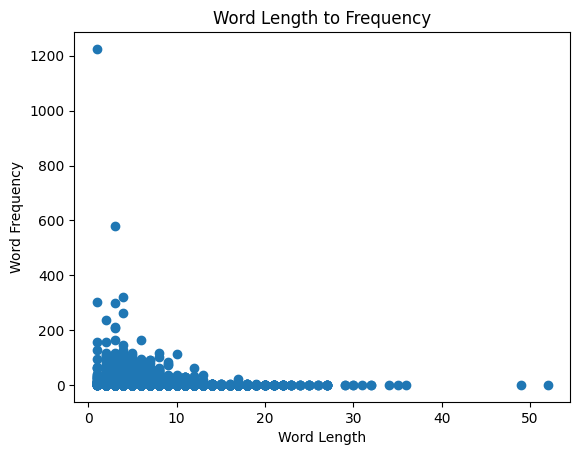

In [13]:
plt.scatter(word_length, word_frequency)
plt.xlabel('Word Length')
plt.ylabel('Word Frequency')
plt.title('Word Length to Frequency')
plt.show()

In [14]:
data["text_reduced"] = data.apply(lambda x: removeShortAndInfrequentWords(x['text_filtered'], frequency), axis=1)
data

,id,keyword,location,text,target,text_filtered,tokens,text_reduced
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason earthquake May ALLAH Forgive u,"[Our, Deeds, Reason, earthquake, May, ALLAH, F...",Reason earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]",Forest fire near Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All resident asked shelter place notified off...,"[All, resident, asked, shelter, place, notifie...",resident asked shelter place officer evacuati...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation orde...,"[13000, people, receive, wildfire, evacuation,...",13000 people wildfire evacuation order Califo...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby Alaska smoke wildfir...,"[Just, got, sent, photo, Ruby, Alaska, smoke, ...",Just sent photo Alaska smoke wildfire school
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant crane holding bridge collapse nearb...,"[Two, giant, crane, holding, bridge, collapse,...",giant crane holding bridge collapse nearby home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary TheTawniest The control wild fire ...,"[ariaahrary, TheTawniest, The, control, wild, ...",control wild fire California even Northern pa...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M194 0104 UTC5km S Volcano Hawaii httptcozDto...,"[M194, 0104, UTC5km, S, Volcano, Hawaii, httpt...",M194 0104 Volcano Hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating ebike collided car Littl...,"[Police, investigating, ebike, collided, car, ...",Police investigating collided Little rider su...


In [15]:
data["tokens"] = data.apply(lambda x: tokenize(x['text_reduced']), axis=1)
vocabulary = np.concatenate(data["tokens"].tolist())
vocabulary = nltk.Text(vocabulary)
frequency = nltk.FreqDist(vocabulary)

In [16]:
len(frequency)

4226

In [17]:
word_frequency = []
word_length = []
for word in frequency.keys():
    word_frequency.append(frequency[word])
    word_length.append(len(word))

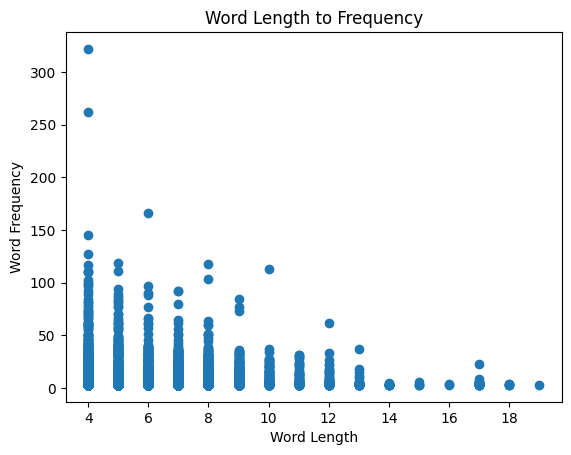

In [18]:
plt.scatter(word_length, word_frequency)
plt.xlabel('Word Length')
plt.ylabel('Word Frequency')
plt.title('Word Length to Frequency')
plt.show()

<Axes: xlabel='target'>

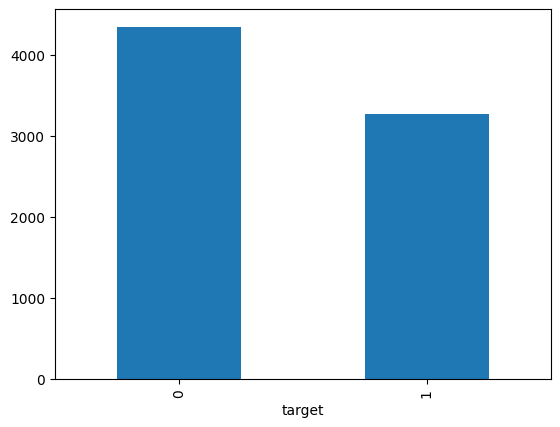

In [19]:
data["target"].value_counts().plot(kind="bar")

### Exploratory Data Analysis

In order to train on the vectors of words we generated above, we use a Keras tokenizer to convert the sentences into padded sequences that indicate the list of words used in a tweet. This can be thought of as a "bag of words" model where we train simply on the list of words that are in the tweet and may lose some context between connected words or similar meanings. However this also makes the model simple, and avoids any assumptions that may exist in pretrained options, so it works effectively for an initial model, especially when looking at something like disaster tweets where many specific words indicate disasters, such as "fire, flood, etc."

Alternatives that could be considered include Word2Vec or GloVe, where additional information can be provided to the dictionary by context around a word. For example the words "fire" "forest" and "helicopter" that are all often used together may have a similar vector, so any of them provides similar information to the model. We also could consider using tuples of words that appear in tweets as characters, however the limited computing resources this notebook is being run on could not handle the increased dictionary.

Instead, since our resources were limited, we test with two different types of models instead. Both models take an initial embedding layer followed by a dropout, but our first model uses an LSTM layer while the next uses a GRU layer, and our third model uses two LSTM layers. We expect the LSTM to be more effective in this model as long as we control for overfitting, as it has more parameters to modify than the GRU layers, and these models are relatively small, so we anticipate that the LSTM will not lead to the overfitting it can be prone to. Since this is a binary classifier we choose a sigmoid for our output layer.

In [20]:
tokenizer = Tokenizer(num_words=len(frequency), split=' ')
tokenizer.fit_on_texts(data['text_reduced'].values)
data_sequences = tokenizer.texts_to_sequences(data['text_reduced'].values)
data_sequences = pad_sequences(data_sequences)

In [21]:
data_sequences

array([[   0,    0,    0, ...,    0,  451,  124],
       [   0,    0,    0, ...,    2,  122, 1415],
       [   0,    0,    0, ...,  370,  287,  852],
       ...,
       [   0,    0,    0, ..., 3323,  425, 1172],
       [   0,    0,    0, ...,  966, 1882,   60],
       [   0,    0,    0, ...,   24,   53,    4]], dtype=int32)

In [22]:
X_train, X_validate, y_train, y_validate = train_test_split(data_sequences, data["target"], stratify=data["target"], test_size=0.2)

In [23]:
def lstm_model_builder(params):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(len(frequency), params.Int("embedding_size", min_value=32, max_value=256, step=32), input_length = X_train.shape[1]))
    model.add(keras.layers.SpatialDropout1D(params.Float("do", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.LSTM(params.Int("lstm_size", min_value=32, max_value=256, step=32), 
                                dropout=params.Float("do_1", min_value=0.1, max_value=0.5, step=0.1), 
                                recurrent_dropout=params.Float("rdo", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_1", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_2", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_3", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_3", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_4", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

    return model

In [24]:
lstm_tuner = keras_tuner.RandomSearch(
    hypermodel=lstm_model_builder,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="models",
    project_name="disaster_tweets",
)  

I0000 00:00:1728728505.325771  389783 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-12 06:21:45.326550: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/midelan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
lstm_tuner.search(X_train, y_train, epochs=2, validation_data=(X_validate,y_validate))

Trial 3 Complete [00h 00m 05s]
val_accuracy: 0.7885752022266388

Best val_accuracy So Far: 0.800065666437149
Total elapsed time: 00h 00m 23s


In [26]:
models = lstm_tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

/home/midelan/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 16, 256)        │     1,081,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 16, 256)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 224)            │       430,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,520,849 (5.80 MB)

 Trainable params: 1,520,849 (5.80 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
lstm_best_hps = lstm_tuner.get_best_hyperparameters(1)
lstm_final_model = lstm_model_builder(lstm_best_hps[0])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

final_lstm_model_history = lstm_final_model.fit(X_train, 
                              y_train, 
                              epochs = 10, 
                              batch_size=1000, 
                              verbose = 1, 
                              callbacks=[callback], 
                              validation_data=(X_validate,y_validate))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5381 - loss: 0.6910 - val_accuracy: 0.5706 - val_loss: 0.6706
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5490 - loss: 0.6800 - val_accuracy: 0.5706 - val_loss: 0.6715
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5644 - loss: 0.6748 - val_accuracy: 0.5706 - val_loss: 0.6532
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5659 - loss: 0.6606 - val_accuracy: 0.5706 - val_loss: 0.6328
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5857 - loss: 0.6450 - val_accuracy: 0.5706 - val_loss: 0.6227
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6316 - loss: 0.6193 - val_accuracy: 0.7722 - val_loss: 0.5781
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7034 - loss: 0.5799 - val_accuracy: 0.7912 - val_loss: 0.5400
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7555 - loss: 0.5360 - val_accuracy: 0.7978 - val_loss: 0.5144


In [28]:
def gru_model_builder(params):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(len(frequency), params.Int("embedding_size", min_value=32, max_value=256, step=32), input_length = X_train.shape[1]))
    model.add(keras.layers.SpatialDropout1D(params.Float("do", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Bidirectional(keras.layers.GRU(params.Int("gru_size", min_value=16, max_value=128, step=16))))
    model.add(keras.layers.Dense(params.Int("dense_size_1", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_2", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_3", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_3", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_4", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

    return model

In [29]:
gru_tuner = keras_tuner.RandomSearch(
    hypermodel=gru_model_builder,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="models",
    project_name="disaster_tweets",
)  

In [30]:
gru_tuner.search(X_train, y_train, epochs=2, validation_data=(X_validate,y_validate))

Trial 3 Complete [00h 00m 08s]
val_accuracy: 0.7974392771720886

Best val_accuracy So Far: 0.8046618402004242
Total elapsed time: 00h 00m 23s


In [31]:
models = gru_tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

/home/midelan/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 16, 96)         │       405,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 16, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 192)            │       111,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 112)            │        14,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         5,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,065 (2.14 MB)

 Trainable params: 562,065 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
gru_best_hps = gru_tuner.get_best_hyperparameters(1)
gru_final_model = gru_model_builder(gru_best_hps[0])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

final_gru_model_history = gru_final_model.fit(X_train, 
                              y_train, 
                              epochs = 10, 
                              batch_size=1000, 
                              verbose = 1, 
                              callbacks=[callback], 
                              validation_data=(X_validate,y_validate))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5038 - loss: 0.6919 - val_accuracy: 0.5706 - val_loss: 0.6818
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5701 - loss: 0.6820 - val_accuracy: 0.5706 - val_loss: 0.6739
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5736 - loss: 0.6718 - val_accuracy: 0.5778 - val_loss: 0.6492
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6095 - loss: 0.6369 - val_accuracy: 0.7571 - val_loss: 0.5964
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7707 - loss: 0.5802 - val_accuracy: 0.7827 - val_loss: 0.5250
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8310 - loss: 0.4666 - val_accuracy: 0.7997 - val_loss: 0.4933
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8527 - loss: 0.3914 - val_accuracy: 0.7951 - val_loss: 0.5036
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8783 - loss: 0.3327 - val_accuracy: 0.7905 - val_loss: 0.4819


In [33]:
def extended_lstm_model_builder(params):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(len(frequency), params.Int("embedding_size", min_value=32, max_value=256, step=32), input_length = X_train.shape[1]))
    model.add(keras.layers.SpatialDropout1D(params.Float("do", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.LSTM(params.Int("lstm_size_1", min_value=32, max_value=256, step=32), 
                                dropout=params.Float("do_1", min_value=0.1, max_value=0.5, step=0.1), 
                                recurrent_dropout=params.Float("rdo_1", min_value=0.1, max_value=0.5, step=0.1),
                                return_sequences=True))
    model.add(keras.layers.LSTM(params.Int("lstm_size_2", min_value=32, max_value=256, step=32), 
                                dropout=params.Float("do_2", min_value=0.1, max_value=0.5, step=0.1), 
                                recurrent_dropout=params.Float("rdo_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_1", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_3", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_2", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_4", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(params.Int("dense_size_3", min_value=16, max_value=128, step=16),activation='relu'))
    model.add(keras.layers.Dropout(params.Float("do_5", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

    return model

In [34]:
extended_lstm_tuner = keras_tuner.RandomSearch(
    hypermodel=extended_lstm_model_builder,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="models",
    project_name="disaster_tweets",
)  

In [35]:
extended_lstm_tuner.search(X_train, y_train, epochs=2, validation_data=(X_validate,y_validate))

Trial 3 Complete [00h 00m 10s]
val_accuracy: 0.8003939390182495

Best val_accuracy So Far: 0.8023637533187866
Total elapsed time: 00h 00m 33s


In [36]:
models = extended_lstm_tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 16, 128)        │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 16, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16, 160)        │       184,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,817 (3.36 MB)

 Trainable params: 880,817 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
extended_lstm_best_hps = extended_lstm_tuner.get_best_hyperparameters(1)
extended_lstm_final_model = extended_lstm_model_builder(lstm_best_hps[0])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

final_extended_lstm_model_history = extended_lstm_final_model.fit(X_train, 
                              y_train, 
                              epochs = 20, 
                              batch_size=1000, 
                              verbose = 1, 
                              callbacks=[callback], 
                              validation_data=(X_validate,y_validate))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4863 - loss: 0.6939 - val_accuracy: 0.5706 - val_loss: 0.6902
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5704 - loss: 0.6896 - val_accuracy: 0.5706 - val_loss: 0.6845
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5729 - loss: 0.6835 - val_accuracy: 0.5706 - val_loss: 0.6748
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5689 - loss: 0.6786 - val_accuracy: 0.5706 - val_loss: 0.6690
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5653 - loss: 0.6762 - val_accuracy: 0.5706 - val_loss: 0.6616
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5714 - loss: 0.6629 - val_accuracy: 0.5706 - val_loss: 0.6467
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5920 - loss: 0.6476 - val_accuracy: 0.7019 - val_loss: 0.6198
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6978 - loss: 0.6137 - val_accuracy: 0.7656 - val_loss: 0.5691


### Results and Analysis

For each of the three models described above, we set up Keras hyperparameter tuners to walk through the layer size and dropout rates of each layer, and the learning rates of each model, and graph our train/test results below. We see clear indications of overfitting in both the GRU and the Extended LSTM models with our test loss increasing after 5-10 epochs. However the baseline LSTM model does not show any such indications after it completes training and achieves a respectable ~79% validation accuracy during training, so we choose to move forwards with that model.

Using our unlabelled test data we perform the same data manipulations as we performed on the test data, but only keep words found in our training dictionary as any word not known to our dictionary would be meaningless in terms of the model. We observe in a sample of the test data with predictions appended that it appears we are successfully detecting most disaster tweets, although some with special characters and place names seem to evade this model. As a sanity check we validate that we produce a ratio of disaster to non disaster tweets roughly similar to the training data.

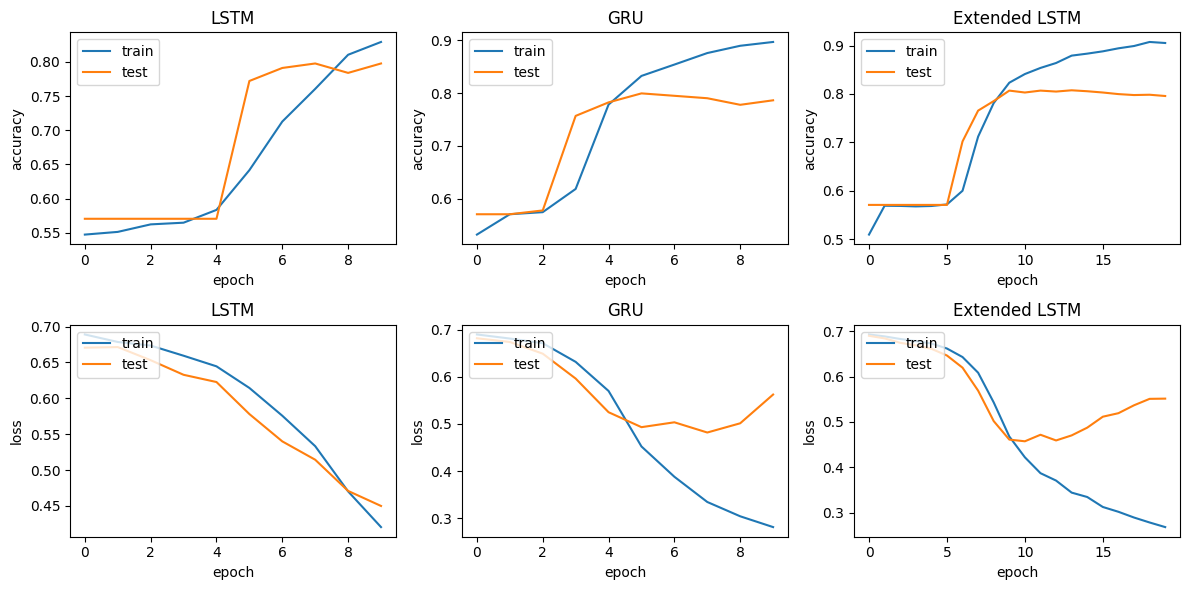

In [38]:
fig, axs = plt.subplots(2,3,figsize=(12, 6))
histories = [final_lstm_model_history,final_gru_model_history,final_extended_lstm_model_history]
names = ["LSTM","GRU","Extended LSTM"]
index = 0
for history in histories:
    ax = axs[0,index]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.title.set_text(names[index])
    ax.set(xlabel='epoch', ylabel='accuracy')
    ax.legend(['train', 'test'], loc='upper left')
    index = index+1

index = 0
for history in histories:
    ax = axs[1,index]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.title.set_text(names[index])
    ax.set(xlabel='epoch', ylabel='loss')
    ax.legend(['train', 'test'], loc='upper left')
    index = index+1
plt.tight_layout()
plt.show()

In [39]:
predictions = lstm_final_model.evaluate(X_validate, y_validate, batch_size=128)
predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8032 - loss: 0.4446


[0.449951171875, 0.7977675795555115]

In [42]:
def removeWordsNotInDict(text, dictionary):
    tweet = ""
    for word in text.split():
        if (dictionary[word]!=0):
            tweet = tweet + " " + word
    return tweet

In [43]:
test_data_path = os.path.join(os.path.dirname(notebook_path), "RawImports/test.csv")
test_data = pd.read_csv(test_data_path)
test_data["text_filtered"] = test_data.apply(lambda x: removePunctuationAndStops(x['text']), axis=1)
test_data["text_reduced"] = test_data.apply(lambda x: removeWordsNotInDict(x['text_filtered'], frequency), axis=1)
test_data_sequences = tokenizer.texts_to_sequences(test_data['text_reduced'].values)
test_data_sequences = pad_sequences(test_data_sequences)

In [45]:
test_data_sequences

array([[   0,    0,    0, ...,  674, 1829,   17],
       [   0,    0,    0, ...,  384, 1360,  128],
       [   0,    0,    0, ...,  667,  371,  201],
       ...,
       [   0,    0,    0, ...,  463,  223, 1105],
       [   0,    0,    0, ...,  336,  136, 1279],
       [   0,    0,    0, ..., 1395,    7,   88]], dtype=int32)

In [72]:
predictions=lstm_final_model.predict(test_data_sequences) 
test_data['target'] = predictions
test_data.loc[test_data['target'] <= 0.5, 'target'] = 0
test_data.loc[test_data['target'] > 0.5, 'target'] = 1
test_data.target = test_data.target.astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [73]:
test_data


,id,keyword,location,text,text_filtered,text_reduced,target
0,0,NaN,NaN,Just happened a terrible car crash,Just happened terrible car crash,Just happened terrible crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard earthquake different city stay safe eve...,earthquake different city stay safe everyone,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across st...,forest fire spot pond across street save,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfire,Apocalypse lighting wildfire,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kill 28 China Taiwan,Typhoon Soudelor kill China Taiwan,1
...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FAST...,,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm RI worse last hurricane My cityamp3othe...,Storm worse last hurricane look like bombed A...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment Chicago httptcoUtbXLcBIuY,Green Line derailment Chicago,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issue Hazardous Weather Outlook HWO httpt...,issue Hazardous Weather Outlook,1


<Axes: xlabel='target'>

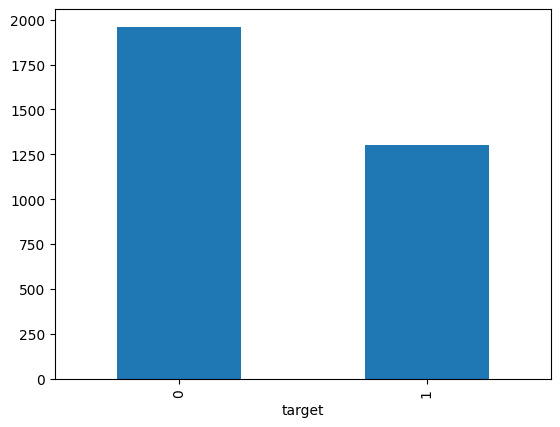

In [75]:
test_data["target"].value_counts().plot(kind="bar")

In [80]:
output = test_data[["id","target"]]
output.to_csv(os.path.join(os.path.dirname(notebook_path), "output.csv"), index=False)

### Conclusion

As can be seen in the screenshot in the associated Github repo the test data projections obtained a score of 78.76%, again, a respectable score for an initial proof of concept model that indicates this would be a good route for additional exploration. Especially since this is almost identical to our validation and training accuracy during training so it is likely that simply running the existing model longer would produce an improvement as we have not yet hit overfitting.

For additional research, there are a few items already mentioned in this report that may be of particular interest:

Using the location data, especially if a dataset with more thorough geolocation data could be found. Disasters likely have many tweets in a short period of time and a small geographical area when the disaster occurs, so it is possible that a model could be devised that not only considers the meaning of an individual tweet, but also the volume of tweets with the same meaning in a given time period and geographical location.

If we are using the existing dataset, the consider augmenting the bag of words approach with a Word2Vec or GloVe model to provide additional context to the words used from wider training on other sources, or extend our bag of words to include ngrams of words if using additional computing power that can handle the additional dictionary entries.